In [ ]:
All variables in input + MLP (for context)

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 1. Loading libraries and datasets, and set up data
# ───────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (Input, LSTM, Embedding, Flatten, Dense, Concatenate, SpatialDropout1D, BatchNormalization, Dropout, Add, RepeatVector)
from tensorflow.keras.models import Model
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

# Cluster, PH, Weather, Sales data
df = pd.read_csv(r" ... csv")

# Feature columns
time_varying_categorical_cols = ['Rain?','Name','Puasa','Public Holiday','Day','Month']  # varies with time
static_categorical_cols = ['Store_No','State','CODE (subcluster 1)','CODE FY26 1 (subcluster 2)','CODE FY26 2 (subcluster 3)']  # won't change depending on time
categorical_cols = time_varying_categorical_cols + static_categorical_cols
numeric_cols = ['Net_Amount','TC','Days_after_Opening','Average Daily Temperature (°C)']

# Filling in spaces to be encoded: 'CODE (subcluster 1)': blank, Name: no PH, Puasa: 0, Public Holiday: 0
# Filling empty spaces
df['CODE (subcluster 1)'] = df['CODE (subcluster 1)'].fillna('blank')
df['Name']               = df['Name'].fillna('no PH')
df['Puasa']              = df['Puasa'].fillna(0)
df['Public Holiday']     = df['Public Holiday'].fillna(0)

# Replace any empty‐string entries (''), if they exist
df['CODE (subcluster 1)'] = df['CODE (subcluster 1)'].replace('', 'blank')
df['Name']               = df['Name'].replace('', 'no PH')
df['Puasa']              = df['Puasa'].replace('', 0)
df['Public Holiday']     = df['Public Holiday'].replace('', 0)

# ───────────────────────────────────────────────────────────────────────────────
# 2. Encoding categorical columns
# ───────────────────────────────────────────────────────────────────────────────
# Splitting categorical columns into 2 types - to be embedded or be binary
embed_cols = []

for col in categorical_cols:
    n_uniques = df[col].nunique()
    if col in static_categorical_cols:
        embed_cols.append(col)
    elif n_uniques < 3:
        pass
    elif n_uniques >= 7:
        embed_cols.append(col)
    else:
        print(f"Column {col} has {n_uniques} categories: choose manually.")

# Encoding embed columns
encoders = {}
for col in embed_cols:
    le = LabelEncoder()
    df[col + '_enc'] = le.fit_transform(df[col])
    encoders[col] = le

# Binary columns - Puasa and Public Holiday are already in 0s and 1s
df['Rain?'] = df['Rain?'].map({'Yes': 1, ' No': 0})

# ───────────────────────────────────────────────────────────────────────────────
# 3. Scaling continuous features
# ───────────────────────────────────────────────────────────────────────────────
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# ───────────────────────────────────────────────────────────────────────────────
# 4. Building sequences for LSTM
# ───────────────────────────────────────────────────────────────────────────────
# purely numeric or binary (already scaled / mapped 0/1)
time_numeric_cols = [
    'Net_Amount',
    'TC',
    'Days_after_Opening',
    'Average Daily Temperature (°C)',
    'Rain?',          # make sure this is 0/1
    'Puasa',          # 0/1
    'Public Holiday'  # 0/1
]

# select window size 7-30 days
window = 14

X_num, X_name, X_day, X_month, X_stat, y = [], [], [], [], [], []

static_cols = [col + '_enc' for col in static_categorical_cols if col in embed_cols]

for store_id, grp in df.groupby('Store_No'):
    grp = grp.sort_values('Date')
    T   = len(grp)
    if T <= window: 
        continue

    # raw arrays
    arr_num    = grp[time_numeric_cols].values        # (T, n_num_feats)
    arr_name   = grp['Name_enc'].values               # (T,)
    arr_day    = grp['Day_enc'].values                # (T,)
    arr_month  = grp['Month_enc'].values              # (T,)
    arr_static = grp[static_cols].iloc[window:].values# (T-window, n_static_feats)
    arr_target = grp[['Net_Amount','TC']].values[window:]    # (T-window,)

    for i in range(T - window):
        X_num.append(   arr_num[i : i+window]     )  # → (window, n_num_feats)
        X_name.append(  arr_name[i : i+window]    )  # → (window,)
        X_day.append(   arr_day[i : i+window]     )
        X_month.append(arr_month[i : i+window]    )
        X_stat.append(  arr_static[i]             )  # → (n_static_feats,)
        y.append(       arr_target[i]             )  # → scalar

# stack into arrays
X_num    = np.stack(X_num)    # (N, window, n_num_feats)
X_name   = np.stack(X_name)   # (N, window)
X_day    = np.stack(X_day)    # (N, window)
X_month  = np.stack(X_month)  # (N, window)
X_stat   = np.stack(X_stat)   # (N, n_static_feats)
y        = np.array(y)        # (N,)

print(X_num.shape, X_name.shape, X_day.shape, X_month.shape, X_stat.shape, y.shape)

# ───────────────────────────────────────────────────────────────────────────────
# 5. Time-aware train-validation data split
# ───────────────────────────────────────────────────────────────────────────────
# Initialize empty Python lists to hold your training vs. validation sequences:
X_num_train, X_num_val, \
X_name_train, X_name_val, \
X_day_train,  X_day_val,  \
X_month_train,X_month_val,\
X_stat_train, X_stat_val, \
y_train,      y_val = ([] for _ in range(12))

window = 14
for store_id, grp in df.groupby('Store_No'):
    grp = grp.sort_values('Date')
    T = len(grp)
    n_windows = T - window
    if n_windows <= 0: continue

    # how many windows to train on for this store
    split_store = int(0.8 * n_windows)

    arr_num    = grp[time_numeric_cols].values        # (T, n_num_feats)
    arr_name   = grp['Name_enc'].values               # (T,)
    arr_day    = grp['Day_enc'].values                # (T,)
    arr_month  = grp['Month_enc'].values              # (T,)
    arr_static = grp[static_cols].iloc[window:].values# (T-window, n_static_feats)
    arr_target = grp[['Net_Amount','TC']].values[window:]    # (T-window,)

    for i in range(n_windows):
        num_seq  = arr_num[i : i+window]
        name_seq = arr_name[i : i+window]
        day_seq  = arr_day[i : i+window]
        month_seq = arr_month[i : i+window]
        static = arr_static[i]
        target   = arr_target[i]
        if i < split_store:
            X_num_train.append(num_seq)
            X_name_train.append(name_seq)
            X_day_train.append(day_seq)
            X_month_train.append(month_seq)
            X_stat_train.append(static)
            y_train.append(target)
        else:
            X_num_val.append(num_seq)
            X_name_val.append(name_seq)
            X_day_val.append(day_seq)
            X_month_val.append(month_seq)
            X_stat_val.append(static)
            y_val.append(target)

# finally stack
X_num_train = np.stack(X_num_train)
X_name_train = np.stack(X_name_train)
X_day_train = np.stack(X_day_train)
X_month_train = np.stack(X_month_train)
X_stat_train = np.stack(X_stat_train)
y_train     = np.stack(y_train)

X_stat_train = np.array(X_stat_train)
X_stat_val   = np.array(X_stat_val)

# ───────────────────────────────────────────────────────────────────────────────
# 6. Build, sanity‑check & train the Keras model (with embeddings) + 2-layer resifual MLP on statics
# ───────────────────────────────────────────────────────────────────────────────
def build_sales_lstm(
        W, F, time_cardinalities, static_cardinalities,
        lstm_units   = 64,         # you can tune these
        dropout_rate = 0.25,
        static_dense = 128,
        learning_rate= 1e-3,
):
# --- time-series inputs ---------------------------------------------------
    num_in       = Input(shape=(W, F),           name='num_in')
    name_seq_in  = Input(shape=(W,), dtype='int32', name='name_seq_in')
    day_seq_in   = Input(shape=(W,), dtype='int32', name='day_seq_in')
    month_seq_in = Input(shape=(W,), dtype='int32', name='month_seq_in')

    dim = lambda n: min(100, n // 2 + 5)

    name_emb  = SpatialDropout1D(dropout_rate)(
                   Embedding(time_cardinalities['name'],  dim(time_cardinalities['name']))(name_seq_in))
    day_emb   = SpatialDropout1D(dropout_rate)(
                   Embedding(time_cardinalities['day'],   dim(time_cardinalities['day']))(day_seq_in))
    month_emb = SpatialDropout1D(dropout_rate)(
                   Embedding(time_cardinalities['month'], dim(time_cardinalities['month']))(month_seq_in))

    time_concat = Concatenate(axis=-1)([num_in, name_emb, day_emb, month_emb])

    # --- static branch: **deeper residual** ----------------------------------
    static_inputs, static_vecs = [], []
    for base, vocab in static_cardinalities:
        s_in = Input(shape=(1,), dtype='int32', name=f'{base}_in')  # ✅ correct
        s_emb = Embedding(vocab, dim(vocab))(s_in)
        s_emb = Flatten()(s_emb)
        static_inputs.append(s_in)
        static_vecs.append(s_emb)

    static_ctx = Concatenate()(static_vecs)             # concat raw embeddings

    # MLP block 1
    h = Dense(static_dense, 'relu')(static_ctx)
    h = BatchNormalization()(h)
    h = Dropout(dropout_rate)(h)
    # MLP block 2 with RESIDUAL skip
    h2 = Dense(static_dense, 'relu')(h)
    h2 = BatchNormalization()(h2)
    h2 = Dropout(dropout_rate)(h2)
    h  = Add()([h, h2])                                # residual connection

    # final compressed static context
    static_ctx = Dense(static_dense//2, 'relu')(h)
    static_ctx = BatchNormalization()(static_ctx)

    # ---- tile & state-init exactly like 6.1 ---------------------------------
    static_tile = RepeatVector(W)(static_ctx)
    time_concat = Concatenate(-1)([time_concat, static_tile])

    init_h = Dense(lstm_units, 'tanh')(static_ctx)
    init_c = Dense(lstm_units, 'tanh')(static_ctx)

    x = LSTM(lstm_units, dropout=0.0)(time_concat,
                                      initial_state=[init_h, init_c])
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(2, 'linear')(x)

    model = Model(
        inputs=[num_in, name_seq_in, day_seq_in, month_seq_in] + static_inputs,
        outputs=out, name='Sales_LSTM_TiledResidual')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mse', metrics=['mae'])
    return model


# Prepare cardinalities for embeddings
n_name  = df['Name_enc' ].nunique()
n_day   = df['Day_enc'  ].nunique()
n_month = df['Month_enc'].nunique()
time_cardinalities = {'name': n_name, 'day': n_day, 'month': n_month}

static_cardinalities = []
for enc_col in static_cols:                      # e.g. "Store_No_enc"
    base  = enc_col.replace('_enc','')           # "Store_No"
    vocab = df[enc_col].nunique()
    static_cardinalities.append((base, vocab))

# window & feature count
_, W, F = X_num.shape

# Cast *all* arrays to proper dtype and shape
X_num_train   = np.asarray(X_num_train,   dtype=np.float32)
X_num_val     = np.asarray(X_num_val,     dtype=np.float32)

def to_int2d(arr): return np.asarray(arr, dtype=np.int32)
X_name_train  = to_int2d(X_name_train)
X_day_train   = to_int2d(X_day_train)
X_month_train = to_int2d(X_month_train)
X_name_val    = to_int2d(X_name_val)
X_day_val     = to_int2d(X_day_val)
X_month_val   = to_int2d(X_month_val)

X_stat_train  = np.asarray(X_stat_train, dtype=np.int32)
X_stat_val    = np.asarray(X_stat_val,   dtype=np.int32)
y_train       = np.asarray(y_train,      dtype=np.float32)
y_val         = np.asarray(y_val,        dtype=np.float32)

# ───────────────────────────────────────────────────────────────────────────────
# 7. Fit Model
# ───────────────────────────────────────────────────────────────────────────────
# Build input dicts (by name ─ safest)
train_inputs = {
    'num_in':       X_num_train,
    'name_seq_in':  X_name_train,
    'day_seq_in':   X_day_train,
    'month_seq_in': X_month_train,
}
val_inputs   = {
    'num_in':       X_num_val,
    'name_seq_in':  X_name_val,
    'day_seq_in':   X_day_val,
    'month_seq_in': X_month_val,
}

# add static columns (need reshape (N,1))
for i, (base, _) in enumerate(static_cardinalities):
    train_inputs[f'{base}_in'] = X_stat_train[:, i].reshape(-1,1)
    val_inputs  [f'{base}_in'] = X_stat_val[:,   i].reshape(-1,1)

# Sanity check: print expected vs actual - make sure ValueError: Functional() don't pop up
print("\n── EXPECTED  vs  ACTUAL per‑sample shapes ──")
tmp_model = build_sales_lstm(W, F, time_cardinalities, static_cardinalities)
for inp in tmp_model.inputs:
    k   = inp.name.split(':')[0]
    exp = tuple(inp.shape[1:])
    act = tuple(train_inputs[k].shape[1:])
    ok  = "✅" if exp == act else "❌"
    print(f"{k:25s} expected={str(exp):12s} actual={str(act):12s} {ok}")
print("────────────────────────────────────────────\n")

# Instantiate final model & train
model = build_sales_lstm(W, F, time_cardinalities, static_cardinalities)
es   = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[es, rlrp],
    verbose=2
)

# Plot training curves
plt.plot(history.history['loss'],     label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.legend(); plt.tight_layout(); plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 8.  Evaluate on a hold‑out test set and generate forecasts
# ───────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Build a fresh 70/15/15 split Train/Val/Test (time‑aware per store) 
def time_aware_split_by_store(df, window, time_numeric_cols, static_cols):
    X_num_tr, X_num_va, X_num_te = [], [], []
    X_name_tr, X_name_va, X_name_te = [], [], []
    X_day_tr,  X_day_va,  X_day_te  = [], [], []
    X_month_tr,X_month_va,X_month_te= [], [], []
    X_stat_tr, X_stat_va, X_stat_te = [], [], []
    y_tr,      y_va,      y_te      = [], [], []

    for _, grp in df.groupby('Store_No'):
        grp = grp.sort_values('Date')
        T = len(grp)
        n_windows = T - window
        if n_windows <= 0: continue

        n_train = int(0.70 * n_windows)
        n_val   = int(0.15 * n_windows)
        # remainder → test
        n_test  = n_windows - n_train - n_val

        arr_num    = grp[time_numeric_cols].values
        arr_name   = grp['Name_enc' ].values
        arr_day    = grp['Day_enc'  ].values
        arr_month  = grp['Month_enc'].values
        arr_static = grp[static_cols].iloc[window:].values
        arr_target = grp[['Net_Amount','TC']].values[window:]

        for i in range(n_windows):
            seq_num   = arr_num[i:i+window]
            seq_name  = arr_name[i:i+window]
            seq_day   = arr_day[i:i+window]
            seq_month = arr_month[i:i+window]
            stat_vec  = arr_static[i]
            target    = arr_target[i]

            # buckets
            if i < n_train:
                bucket = (X_num_tr,  X_name_tr,  X_day_tr,  X_month_tr,  X_stat_tr,  y_tr)
            elif i < n_train + n_val:
                bucket = (X_num_va,  X_name_va,  X_day_va,  X_month_va,  X_stat_va,  y_va)
            else:
                bucket = (X_num_te,  X_name_te,  X_day_te,  X_month_te,  X_stat_te,  y_te)

            bucket[0].append(seq_num)
            bucket[1].append(seq_name)
            bucket[2].append(seq_day)
            bucket[3].append(seq_month)
            bucket[4].append(stat_vec)
            bucket[5].append(target)

    # stack to np arrays
    def _stack(lst): return np.stack(lst) if lst and isinstance(lst[0], np.ndarray) else np.array(lst)
    return tuple(map(_stack,
        [X_num_tr,X_num_va,X_num_te,
         X_name_tr,X_name_va,X_name_te,
         X_day_tr,X_day_va,X_day_te,
         X_month_tr,X_month_va,X_month_te,
         X_stat_tr,X_stat_va,X_stat_te,
         y_tr,y_va,y_te]))

# build split
(split_X_num_tr, split_X_num_va, split_X_num_te,
 split_X_name_tr, split_X_name_va, split_X_name_te,
 split_X_day_tr,  split_X_day_va,  split_X_day_te,
 split_X_month_tr,split_X_month_va,split_X_month_te,
 split_X_stat_tr, split_X_stat_va, split_X_stat_te,
 split_y_tr,      split_y_va,      split_y_te) = time_aware_split_by_store(
    df, window, time_numeric_cols, static_cols
)

# Assemble TEST input dict 
def build_input_dict(X_num,X_name,X_day,X_month,X_stat):
    d = {
        'num_in':       X_num.astype(np.float32),
        'name_seq_in':  X_name.astype(np.int32),
        'day_seq_in':   X_day.astype(np.int32),
        'month_seq_in': X_month.astype(np.int32)
    }
    for i,(base,_) in enumerate(static_cardinalities):
        d[f'{base}_in'] = X_stat[:,i].reshape(-1,1).astype(np.int32)
    return d

test_inputs = build_input_dict(
    split_X_num_te, split_X_name_te, split_X_day_te,
    split_X_month_te, split_X_stat_te)

# Predict on the test set
y_pred_scaled = model.predict(test_inputs, verbose=0)

# Inverse‑scale Net_Amount & TC
# remember scaler was fit on numeric_cols, where Net_Amount is col 0 and TC is col 1
# we’ll invert only those two columns
net_idx = numeric_cols.index('Net_Amount')
tc_idx  = numeric_cols.index('TC')

def inverse_scale(scaled_vec, col_idx):
    tmp      = np.zeros((len(scaled_vec), len(numeric_cols)))
    tmp[:,col_idx] = scaled_vec
    return scaler.inverse_transform(tmp)[:,col_idx]

net_pred = inverse_scale(y_pred_scaled[:,0], net_idx)
tc_pred  = inverse_scale(y_pred_scaled[:,1], tc_idx)

net_true = inverse_scale(split_y_te[:,0], net_idx)
tc_true  = inverse_scale(split_y_te[:,1], tc_idx)

# Metrics & Interpretation
def interpret(true, pred, name):
    # core metrics
    mae  = mean_absolute_error(true, pred)
    rmse = math.sqrt(mean_squared_error(true, pred))
    r2   = r2_score(true, pred)

    # reference stats
    mean_y = np.mean(true)
    std_y  = np.std(true)

    # relative ratios
    mae_ratio  = mae  / mean_y  if mean_y else float('nan')
    rmse_ratio = rmse / std_y   if std_y  else float('nan')

    # header
    print(f"\n=== {name} ===")
    print(f" MAE : {mae:8.2f}   (mean = {mean_y:8.2f}, MAE/mean = {mae_ratio:.2f})")
    print(f" RMSE: {rmse:8.2f}   (std  = {std_y:8.2f}, RMSE/std  = {rmse_ratio:.2f})")
    print(f" R²  : {r2:6.3f}")

    # interpret MAE‑to‑mean
    if mae_ratio < 0.10:
        print("   🔵 Excellent MAE (<10% of mean)")
    elif mae_ratio < 0.20:
        print("   🟢 Good MAE (<20% of mean)")
    elif mae_ratio < 0.30:
        print("   🟡 Acceptable MAE (<30% of mean)")
    else:
        print("   🔴 Poor MAE (>30% of mean)")

    # interpret RMSE‑to‑std
    if rmse_ratio < 0.50:
        print("   🔵 Excellent RMSE (<0.5 σ)")
    elif rmse_ratio < 0.75:
        print("   🟢 Good RMSE (<0.75 σ)")
    elif rmse_ratio < 1.00:
        print("   🟡 Acceptable RMSE (<1.0 σ)")
    else:
        print("   🔴 Poor RMSE (>1.0 σ)")

    # interpret R²
    if r2 >= 0.90:
        print("   🔵 Excellent R² (≥0.90)")
    elif r2 >= 0.75:
        print("   🟢 Good R² (0.75–0.90)")
    elif r2 >= 0.50:
        print("   🟡 Acceptable R² (0.50–0.75)")
    else:
        print("   🔴 Weak R² (<0.50)")

# run it for both targets
interpret(net_true, net_pred, "Net_Amount")
interpret(tc_true,  tc_pred,  "TC")

# Visual check for Net_Amount
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].scatter(net_true, net_pred, alpha=.4)
ax[0].plot([net_true.min(), net_true.max()],
           [net_true.min(), net_true.max()], 'k--')
ax[0].set_xlabel("True Net_Amount"); ax[0].set_ylabel("Predicted")
ax[0].set_title("Net_Amount – scatter")

ax[1].plot(net_true[:200], label='True')    # first 200 horizon windows
ax[1].plot(net_pred[:200], label='Pred', alpha=.7)
ax[1].set_title("Net_Amount – first 200 forecast windows")
ax[1].legend()

plt.tight_layout(); plt.show()

# Visual check for TC
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].scatter(tc_true, tc_pred, alpha=.4)
ax[0].plot([tc_true.min(), tc_true.max()],
           [tc_true.min(), tc_true.max()], 'k--')
ax[0].set_xlabel("True TC"); ax[0].set_ylabel("Predicted")
ax[0].set_title("TC – scatter")

ax[1].plot(tc_true[:200], label='True')    # first 200 horizon windows
ax[1].plot(tc_pred[:200], label='Pred', alpha=.7)
ax[1].set_title("TC – first 200 forecast windows")
ax[1].legend()

plt.tight_layout(); plt.show()

Baseline RMSE = 1015.99


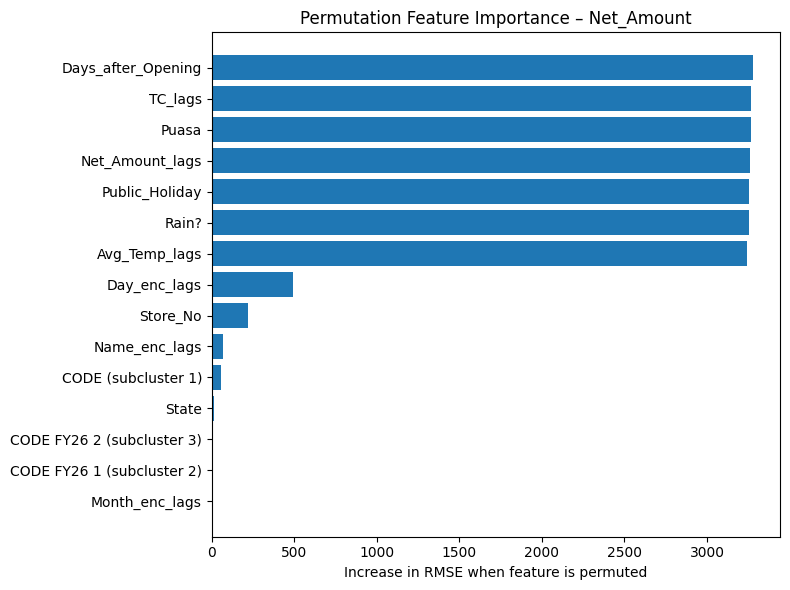

Baseline TC RMSE = 62.41


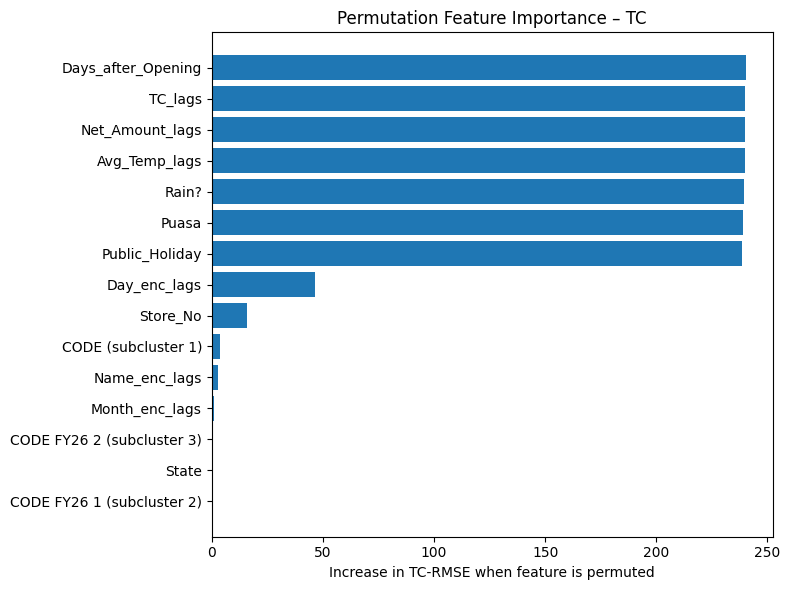

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 9. Checking Feature Importance
# ───────────────────────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
import copy
from collections import OrderedDict
from sklearn.metrics import mean_squared_error

# Helper: inverse-scale a single column (we already defined earlier)
def inverse_scale(scaled_vec, col_idx):
    tmp              = np.zeros((len(scaled_vec), len(numeric_cols)))
    tmp[:, col_idx]  = scaled_vec
    return scaler.inverse_transform(tmp)[:, col_idx]

# Baseline error on Net_Amount (choose whichever target you care about)
base_pred = model.predict(test_inputs, verbose=0)[:, 0]      # column 0 = Net_Amount
base_pred = inverse_scale(base_pred, numeric_cols.index('Net_Amount'))
base_true = inverse_scale(split_y_te[:, 0], numeric_cols.index('Net_Amount'))
base_mse  = mean_squared_error(base_true, base_pred)

print(f"Baseline RMSE = {np.sqrt(base_mse):.2f}")

# Define groups of columns that belong to one logical feature
# build a dict: { "display name": list[ key(s) in test_inputs ] }
groups = OrderedDict({
    # time-series numeric (whole sequence counts as one logical feature)
    "Net_Amount_lags" : ["num_in"],   # but we'll permute only the Net column inside num_in
    "TC_lags"         : ["num_in"],
    "Days_after_Opening": ["num_in"],
    "Avg_Temp_lags"   : ["num_in"],
    "Rain?"           : ["num_in"],
    "Puasa"           : ["num_in"],
    "Public_Holiday"  : ["num_in"],

    # time-categorical
    "Name_enc_lags"   : ["name_seq_in"],
    "Day_enc_lags"    : ["day_seq_in"],
    "Month_enc_lags"  : ["month_seq_in"],

    # static categoricals – each has its own input tensor
})
for base, _ in static_cardinalities:
    groups[base] = [f"{base}_in"]

# Permutation importance loop
importances = OrderedDict()
rng = np.random.default_rng(42)

for gname, keys in groups.items():
    # make a deep copy of the original dict
    perturbed = {k: v.copy() for k, v in test_inputs.items()}

    for k in keys:
        arr = perturbed[k]
        # permute **independently for each timestep** if 3-D, else shuffle axis-0
        if arr.ndim == 3:          # (N, window, features)
            flat = arr.reshape(arr.shape[0], -1)
            rng.shuffle(flat, axis=0)
            perturbed[k] = flat.reshape(arr.shape)
        else:                      # (N,1) or (N,window)
            rng.shuffle(arr, axis=0)
            perturbed[k] = arr

    # predict with the corrupted feature(s)
    y_perm = model.predict(perturbed, verbose=0)[:, 0]
    y_perm = inverse_scale(y_perm, numeric_cols.index('Net_Amount'))
    perm_mse = mean_squared_error(base_true, y_perm)

    importances[gname] = np.sqrt(perm_mse) - np.sqrt(base_mse)  # Δ RMSE

# Plot
names  = list(importances.keys())
scores = np.array(list(importances.values()))
order  = np.argsort(scores)[::-1]         # highest impact first

plt.figure(figsize=(8,6))
plt.barh(np.array(names)[order], scores[order])
plt.xlabel("Increase in RMSE when feature is permuted")
plt.title("Permutation Feature Importance – Net_Amount")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 9. (now for TC)
# ───────────────────────────────────────────────────────────────────────────────
# Baseline TC predictions & RMSE
base_pred_tc = model.predict(test_inputs, verbose=0)[:, 1]  # pick the TC column
base_pred_tc = inverse_scale(base_pred_tc, numeric_cols.index('TC'))
base_true_tc = inverse_scale(split_y_te[:, 1], numeric_cols.index('TC'))
base_mse_tc  = mean_squared_error(base_true_tc, base_pred_tc)
print(f"Baseline TC RMSE = {np.sqrt(base_mse_tc):.2f}")

#  Same groups dictionary from before
importances_tc = OrderedDict()
for gname, keys in groups.items():
    perturbed = {k: v.copy() for k, v in test_inputs.items()}
    for k in keys:
        arr = perturbed[k]
        if arr.ndim == 3:
            flat = arr.reshape(arr.shape[0], -1)
            rng.shuffle(flat, axis=0)
            perturbed[k] = flat.reshape(arr.shape)
        else:
            rng.shuffle(arr, axis=0)
            perturbed[k] = arr

    # predict on permuted data, then inverse-scale TC
    y_p_tc = model.predict(perturbed, verbose=0)[:, 1]
    y_p_tc = inverse_scale(y_p_tc, numeric_cols.index('TC'))
    imp_mse = mean_squared_error(base_true_tc, y_p_tc)

    importances_tc[gname] = np.sqrt(imp_mse) - np.sqrt(base_mse_tc)

# Plot TC importances
names_tc  = list(importances_tc.keys())
scores_tc = np.array(list(importances_tc.values()))
order_tc  = np.argsort(scores_tc)[::-1]

plt.figure(figsize=(8,6))
plt.barh(np.array(names_tc)[order_tc], scores_tc[order_tc])
plt.xlabel("Increase in TC-RMSE when feature is permuted")
plt.title("Permutation Feature Importance – TC")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 10.  200-step autoregressive forecast - not very accurate
# ───────────────────────────────────────────────────────────────────────────────
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder

# Ensure df has full-day and month columns
df['Date']  = pd.to_datetime(df['Date'])
df['Day']   = df['Date'].dt.day_name()            # 'Monday', 'Tuesday', …
df['Month'] = df['Date'].dt.month.astype(str)     # '1' … '12'

# Fit (or re-fit) your Day/Month encoders 
encoders['Day'] = LabelEncoder().fit([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
])
encoders['Month'] = LabelEncoder().fit([str(i) for i in range(1,13)])

# (Re-)attach the encoded columns to df
df['Day_enc']   = encoders['Day'].transform(df['Day'])
df['Month_enc'] = encoders['Month'].transform(df['Month'])

# Prep the last window 
future_horizon = 200
last_date      = df['Date'].max()

tail_df   = df.sort_values('Date').tail(window).copy()
seq_num   = tail_df[time_numeric_cols].values.astype(np.float32)
seq_name  = tail_df['Name_enc'].values.astype(np.int32)
seq_day   = tail_df['Day_enc'].values.astype(np.int32)
seq_month = tail_df['Month_enc'].values.astype(np.int32)

static_vec = tail_df.iloc[-1][static_cols].values.astype(np.int32)

dates_f, net_f, tc_f = [], [], []

# Autoregressive loop 
for step in range(future_horizon):
    # build one-step input dict
    sample_inputs = {
        'num_in':       seq_num[np.newaxis, ...],
        'name_seq_in':  seq_name[np.newaxis, ...],
        'day_seq_in':   seq_day[np.newaxis, ...],
        'month_seq_in': seq_month[np.newaxis, ...],
    }
    for i, (base, _) in enumerate(static_cardinalities):
        sample_inputs[f'{base}_in'] = static_vec[[i]].reshape(1,1)

    # predict & inverse-scale
    yhat_s = model.predict(sample_inputs, verbose=0)[0]
    net_s, tc_s = yhat_s
    net_v = inverse_scale([net_s], numeric_cols.index('Net_Amount'))[0]
    tc_v  = inverse_scale([tc_s],  numeric_cols.index('TC'))[0]

    # record the date + values
    curr_date = last_date + pd.Timedelta(days=step+1)
    dates_f.append(curr_date)
    net_f.append(net_v)
    tc_f.append(tc_v)

    # advance day & month encodings for the *next* step
    next_day_str   = curr_date.day_name()    # full weekday name
    next_month_str = str(curr_date.month)    # '1'–'12'

    seq_day = np.roll(seq_day, -1)
    seq_day[-1] = encoders['Day'].transform([next_day_str])[0]

    seq_month = np.roll(seq_month, -1)
    seq_month[-1] = encoders['Month'].transform([next_month_str])[0]

    # roll the numeric window
    new_row = seq_num[-1].copy()
    new_row[numeric_cols.index('Net_Amount')] = net_s
    new_row[numeric_cols.index('TC')]         = tc_s
    seq_num = np.vstack([seq_num[1:], new_row])

# Build forecast DF & plot
df_forecast = pd.DataFrame({
    'Date':       dates_f,
    'Net_Amount': net_f,
    'TC':         tc_f,
})

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True,
    subplot_titles=('Net_Amount – 200-step Forecast', 'TC – 200-step Forecast'),
    vertical_spacing=0.1
)

# Net_Amount trace
fig.add_trace(
    go.Scatter(
        x=df_forecast['Date'],
        y=df_forecast['Net_Amount'],
        mode='lines+markers',
        name='Net Amount',
        hovertemplate=
            '<b>Date</b>: %{x}<br>'+
            '<b>Net Amount</b>: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# TC trace
fig.add_trace(
    go.Scatter(
        x=df_forecast['Date'],
        y=df_forecast['TC'],
        mode='lines+markers',
        name='TC',
        hovertemplate=
            '<b>Date</b>: %{x}<br>'+
            '<b>Transactions</b>: %{y:.0f}<extra></extra>'
    ),
    row=2, col=1
)

# Layout tweaks
fig.update_layout(
    height=600, width=900,
    hovermode='x unified',           # vertical line at cursor
    title_text='200-Step Autoregressive Forecast',
    margin=dict(t=80, b=40)
)

# Axis labels
fig.update_xaxes(title_text='Date', row=2, col=1)
fig.update_yaxes(title_text='RM',           row=1, col=1)
fig.update_yaxes(title_text='Transactions', row=2, col=1)

fig.show()


In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 11. Forecasts - but can differentiate by store no
# ───────────────────────────────────────────────────────────────────────────────
# defining scale_cols & new inverse_scale
scale_cols = ['Net_Amount', 'TC', 
              'Days_after_Opening', 'Average Daily Temperature (°C)']

def inverse_scale(scaled_vec, col_name):
    """
    scaled_vec: list or array of length N
    col_name : one of scale_cols
    """
    # how many features our scaler was actually fit on?
    n_feats = scaler.min_.shape[0]           # e.g. 4
    tmp     = np.zeros((len(scaled_vec), n_feats))
    idx     = scale_cols.index(col_name)
    tmp[:, idx] = scaled_vec
    return scaler.inverse_transform(tmp)[:, idx]


# Build actuals DF (blue line)
df_actual = (
    df[['Date','Store_No','Net_Amount','TC']].copy()
      .assign(Date=lambda d: pd.to_datetime(d['Date']))
      .query("Date >= '2025-06-17'")
      .sort_values(['Store_No','Date'])
)

# Forecast each store for 21 days (orange line)
all_forecasts = []
future_horizon = 21

df['Date'] = pd.to_datetime(df['Date'])

for store_id in df['Store_No'].unique():
    one = df[df['Store_No']==store_id].sort_values('Date')
    if len(one) < window:
        continue

    tail_df   = one.tail(window).copy()
    last_date = tail_df['Date'].max()

    # time‐series features (7 dims) → seq_num
    seq_num   = tail_df[time_numeric_cols].values.astype(np.float32)
    seq_name  = tail_df['Name_enc'].values.astype(np.int32)
    seq_day   = tail_df['Day_enc'].values.astype(np.int32)
    seq_month = tail_df['Month_enc'].values.astype(np.int32)
    static_vec= tail_df.iloc[-1][static_cols].values.astype(np.int32)

    dates_f, net_f, tc_f = [], [], []

    for step in range(future_horizon):
        # build input dict
        inp = {
            'num_in'      : seq_num[np.newaxis],
            'name_seq_in' : seq_name[np.newaxis],
            'day_seq_in'  : seq_day[np.newaxis],
            'month_seq_in': seq_month[np.newaxis],
        }
        for i,(base,_) in enumerate(static_cardinalities):
            inp[f'{base}_in'] = static_vec[[i]].reshape(1,1)

        # predict (scaled) & inverse‐scale using the NEW function
        y_s       = model.predict(inp, verbose=0)[0]
        net_s, tc_s = y_s
        net_v = inverse_scale([net_s], 'Net_Amount')[0]
        tc_v  = inverse_scale([tc_s],  'TC'        )[0]

        # record date + true‐scale values
        curr_date = last_date + pd.Timedelta(days=step+1)
        dates_f.append(curr_date)
        net_f.append(net_v)
        tc_f .append(tc_v)

        # roll day/month encoding
        day_str   = curr_date.day_name()
        month_str = str(curr_date.month)
        seq_day   = np.roll(seq_day,   -1)
        seq_day[-1]   = encoders['Day'  ].transform([day_str])[0]
        seq_month = np.roll(seq_month, -1)
        seq_month[-1] = encoders['Month'].transform([month_str])[0]

        # roll the numeric window (uses time_numeric_cols indexes)
        new_row = seq_num[-1].copy()
        j0 = time_numeric_cols.index('Net_Amount')
        j1 = time_numeric_cols.index('TC')
        new_row[j0] = net_s
        new_row[j1] = tc_s
        seq_num = np.vstack([seq_num[1:], new_row])

    # assemble DF for this store
    df_fc = pd.DataFrame({
        'Date'      : dates_f,
        'Net_Amount': net_f,
        'TC'        : tc_f,
        'Store_No'  : store_id
    })
    all_forecasts.append(df_fc)

df_all = pd.concat(all_forecasts, ignore_index=True)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

df_actual = pd.read_csv(r" ... csv")
df_actual['Date'] = pd.to_datetime(df_actual['Date'])

# Step 2: Rename columns to match forecast dataframe
df_actual = df_actual.rename(columns={
    'Store No'   : 'Store_No',
    'Net Amount' : 'Net_Amount'
})

# Step 3: Match dtype for merging or plotting later (optional)
df_actual['Store_No'] = df_actual['Store_No'].astype(df_all['Store_No'].dtype)

# Step 4: Negate if necessary
df_actual['Net_Amount'] = df_actual['Net_Amount'] * -1

# Step 5: Sort by date
df_actual = df_actual.sort_values(['Store_No', 'Date'])

# Interactive figure:  "True"  (blue)  vs  "Predicted"  (orange)
def make_fig(store_id):
    act = df_actual.query("Store_No == @store_id").copy()
    fc  = df_all   .query("Store_No == @store_id").copy()

    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True,
        subplot_titles=("Net_Amount", "TC"),
        vertical_spacing=0.08
    )

    # -------- Net_Amount --------
    # Predicted Net (orange) — leave as-is
    fig.add_trace(
        go.Scatter(
            x=fc['Date'], y=fc['Net_Amount'],
            mode='lines+markers',
            name='Predicted Net',
            line=dict(color='orange'),
            legendgroup='pred',
        ),
        row=1, col=1
    )
    # True Net (now with markers)
    fig.add_trace(
        go.Scatter(
            x=act['Date'], y=act['Net_Amount'],
            mode='lines+markers',              # <<— add +markers
            name='True Net',
            line=dict(color='blue'),
            marker=dict(color='blue'),         # ensure markers are blue
            legendgroup='true',
        ),
        row=1, col=1
    )

    # -------- TC --------
    # Predicted TC (orange) — leave as-is
    fig.add_trace(
        go.Scatter(
            x=fc['Date'], y=fc['TC'],
            mode='lines+markers',
            name='Predicted TC',
            line=dict(color='orange'),
            legendgroup='pred',
            showlegend=False,
        ),
        row=2, col=1
    )
    # True TC (now with markers)
    fig.add_trace(
        go.Scatter(
            x=act['Date'], y=act['TC'],
            mode='lines+markers',              # <<— add +markers
            name='True TC',
            line=dict(color='blue'),
            marker=dict(color='blue'),
            legendgroup='true',
            showlegend=False,
        ),
        row=2, col=1
    )

        # ---- cosmetics ----
    fig.update_layout(
            height=600, width=900,
            hovermode='x unified',
            title=f"Store {store_id}: True vs Predicted (21-Day Horizon)",
            legend_title_text=''          # cleaner legend
        )
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="RM",           row=1, col=1)
    fig.update_yaxes(title_text="Transactions", row=2, col=1)

    fig.show()

# Widget 
store_widget = widgets.Dropdown(
    options=sorted(df_all['Store_No'].unique()),
    description='Select Store_No:',
    style={'description_width': 'initial'}
)
out = widgets.interactive_output(make_fig, {'store_id': store_widget})
display(store_widget, out)

Dropdown(description='Select Store_No:', options=(np.int64(1), np.int64(2), np.int64(4), np.int64(7), np.int64…

Output()

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 12. 11 but with 95% confidence interval
# ───────────────────────────────────────────────────────────────────────────────
import numpy as np

# 1) Merge your actuals & predictions over the hold‐out so you can compute residuals
df_merged = (
    df_actual
      .rename(columns={"Net_Amount":"Net_Amount_act","TC":"TC_act"})
      .merge(
         df_all.rename(columns={"Net_Amount":"Net_Amount_pred","TC":"TC_pred"}),
         on=["Store_No","Date"],
         how="inner"
      )
)

# 2) Compute residual std‐dev across all stores & days
sigma_net = np.std(df_merged["Net_Amount_act"] - df_merged["Net_Amount_pred"], ddof=1)
sigma_tc  = np.std(df_merged["TC_act"]         - df_merged["TC_pred"],        ddof=1)

# 3) 95% half‐widths
ci_half_net = 1.96 * sigma_net
ci_half_tc  = 1.96 * sigma_tc

print(f"Global 95% CI half-widths:  Net={ci_half_net:.0f},  TC={ci_half_tc:.1f}")


# Interactive figure:  "True"  (blue)  vs  "Predicted"  (orange)
import numpy as np   # add at top of your file

def make_fig(store_id):
    # just grab your preds & actuals for the display
    act = df_actual.query("Store_No == @store_id")
    fc  = df_all   .query("Store_No == @store_id")

    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True,
        subplot_titles=("Net_Amount", "TC"),
        vertical_spacing=0.08
    )

    # --- Net_Amount with *constant* CI ---
    fig.add_trace(
        go.Scatter(
            x=fc['Date'], y=fc['Net_Amount'],
            mode='lines+markers',
            name='Predicted Net',
            line=dict(color='orange'),
            error_y=dict(
                type='data',
                array=[ci_half_net]*len(fc),  # constant half-width
                visible=True,
                thickness=1.5,
                width=4,
            )
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=act['Date'], y=act['Net_Amount'],
            mode='lines+markers',
            name='True Net',
            line=dict(color='blue'),
            marker=dict(color='blue'),
        ),
        row=1, col=1
    )

    # --- TC with *constant* CI ---
    fig.add_trace(
        go.Scatter(
            x=fc['Date'], y=fc['TC'],
            mode='lines+markers',
            name='Predicted TC',
            line=dict(color='orange'),
            showlegend=False,
            error_y=dict(
                type='data',
                array=[ci_half_tc]*len(fc),
                visible=True,
                thickness=1.5,
                width=4,
            )
        ),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=act['Date'], y=act['TC'],
            mode='lines+markers',
            name='True TC',
            line=dict(color='blue'),
            marker=dict(color='blue'),
            showlegend=False,
        ),
        row=2, col=1
    )

    # layout tweaks
    fig.update_layout(
        height=600, width=900,
        hovermode='x unified',
        title=f"Store {store_id}: True vs Predicted (21-Day Horizon)",
        legend_title_text=''
    )
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="RM",           row=1, col=1)
    fig.update_yaxes(title_text="Transactions", row=2, col=1)

    fig.show()

# Widget – same as before
store_widget = widgets.Dropdown(
    options=sorted(df_all['Store_No'].unique()),
    description='Select Store_No:',
    style={'description_width': 'initial'}
)
out = widgets.interactive_output(make_fig, {'store_id': store_widget})
display(store_widget, out)

Global 95% CI half-widths:  Net=2276,  TC=147.0


Dropdown(description='Select Store_No:', options=(np.int64(1), np.int64(2), np.int64(4), np.int64(7), np.int64…

Output()